Documentation note:

The documentation for the equations gives the corresponding equation numbers to the report.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
from scipy.constants import sigma
from gekko import GEKKO
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
def find_bed_height(x, omega, theta, V_f, rho_b, R, beta, L, d_d):
    c1 = (3*np.tan(theta)*V_f)/(4*np.pi*omega*rho_b)
    c2 = 2*R
    c3 = np.tan(beta)/np.cos(theta)
    def f(h, x): return -c1*(c2*h - h**2)**(-1.5) + c3 # (Equation 1)

    hL = .3 - d_d                # bed height at right endpoint [m]
    sol = odeint(f, hL, x[::-1]) # solve the ODE
    return sol[::-1]


In [3]:
# Numerical parameters for grid
N = 300 # number of grid points 
L_kiln    = 13.7 # m
X = np.linspace(0, L_kiln, N) # x position
dx = (L_kiln - 0)/(N-1)



In [4]:
unheated_oven_length = 0.5

def get_oven_temps(xs, T_burner=(800,), T_room=20):
    # expects a list or tuple of oven temperatures in celcius
    N_burners = len(T_burner)
    x_start = unheated_oven_length
    x_end = L_kiln - unheated_oven_length
    
    x_pos = np.linspace(x_start, x_end, N_burners + 1)
    
    T_oven = T_room * np.ones(xs.shape) # room temp
    
    for x1,x2,T in zip(x_pos[:-1], x_pos[1:], T_burner):
        T_oven[(x1 <= xs) & (xs < x2)] = T
    return T_oven

In [5]:
alles = dict()

def run_model(*args, d_d=0.03, c_z=750, rpm=4, V_f=(800/3600), k_z=0.65, T_g_initial=(273+20), initial_moisture=0.3, T_oven=(800,)):
    m = GEKKO()
    m.time = X # time points

    T_initial = 273 + 80
    T_room = 273 + 20

    T_b = m.Var(T_initial, lb=T_room)
    T_d = m.Var(T_initial, lb=T_room)
    T_g = m.Var(T_g_initial, lb=T_room) #K

    # Operational parameters
    omega = 2 * np.pi * (rpm / 60) # radian / second; angular velocity

    # Model constants
    phi   = 2.5 # degree; slope of kiln in degrees
    phi_rad = phi*np.pi/180 # rad/s; slope of kiln in rad/s
    k_d = k_z                           # watt / m / K; heat conductivity of zeolite deposit [?]
    k_s = 50.2                          # watt / m / K; heat conductivity of steel
    k_water = 0.6                       # watt / m / K; heat conductivity of water
    k_b = k_z                           # watt / m / K; heat conductivity of bulk  
    k_g = 38.25  # for 200 degrees C, to do: apply watervapor ratio

    theta = 63 * np.pi/180 # angle of repose [rad]

    rho_z = 1930     # kg / m^3 ; Density of zeolite http://webmineral.com/data/Faujasite-Na.shtml
    rho_w = 1000     # kg / m^3 ; Density of water
    rho_a =    0.945 # kg / m^3 ; Density of air   (at 100 C)
    rho_s =    0.597 # kg / m^3 ; Density of steam (at 100 C)

    c_w = 4200       # J / Kg / K; specific heat of water
    c_a = 1013       # J / Kg / K; specific heat of air

    # Moisture
    moi_in  = 0.23     # mass %; moisture of zeolite in
    moi_out =  0.03    # mass %; moisture of zeolite out

    # Implement moisture in bed coefficients
    rho_b = rho_z / (1-moi_out)  # kg / m^3 ; Density of steam (at 100 C)
    c_b = c_z * (1 - moi_out) + c_w * moi_out

    # Implement average moisture for bed height calculation
    rho_b_avg = rho_z/(1-moi_out)  # kg / m^3 ; Density of steam (at 100 C)

    rho_b_initial = rho_z/(1-moi_in)  # kg / m^3 ; Density of steam (at 100 C)
    c_b_initial = c_z * (1 - moi_in) + c_w * moi_in

    u_g = 0.3 # Gas velocity (m/s)
    nu_g = 3.455e-5 # Kinematic viscosity of gas at 200degrC #engineeringtoolbox reference

    w_outside =  0.5  # m; un-heated segment width of the kiln

    d_s = 0.03        # m; steel thickness [?] 3-4

    r_so = 1.25 / 2   # m; outer radius of kiln so = steel-oven 
    r_sd = r_so - d_s # m; radius of steel-deposit interface
    r_di = r_sd - d_d # m; inner radius of the deposit

    eps_b = 0.9       # emissivity of bed
    eps_d = 0.9       # emissivity of deposit

    eps_g = 0.9       # emissivity of gas
    alpha_g = 0.9     # absorptivity of gas

    xhi = 0.12        # 0.096 - 0.198, thickness of the gas layer between the solids and the wall
    d_p = 5e-6        # particle diameter of zeolite

    # m; height of zeolite bed (sagitta)
    h_b = find_bed_height(X, omega, theta, V_f, rho_b_avg, r_di, phi_rad, L_kiln, d_d)
    h_b_val = h_b.copy()

    h_b = m.Param(value=h_b)
    
    T_oven_val = get_oven_temps(X, T_oven) + 273
    T_oven = m.Param(value=T_oven_val)

    # Central angle
    beta = 2*m.acos(1 - h_b / r_di) # use Gekko acos functionality
    # Half angle
    beta2 = beta/2


    # Calculate areas of heat exchange
    A_bd = beta*r_di # (Equation 14)
    A_db = A_bd
    A_gb = 2 * m.sqrt(r_di**2 - (r_di-h_b)**2) # (Equation 15)
    A_gd = 2*np.pi*r_di - A_bd # (Equation 16)
    A_so = 2*np.pi*r_so # (Equation 17)

    # Calculate cross section
    A_cross = r_di**2 * m.acos((r_di-h_b)/r_di) - (r_di-h_b)*m.sqrt(2*r_di*h_b-(h_b*h_b)) # (Equation 2)
    
    initial_vol_rate = V_f / rho_z 
    v_b = initial_vol_rate / A_cross # (Equation 3)

    # Overall heat transfer coefficient
    h_s = k_s / (np.log(r_sd / r_so) * r_sd)
    h_d = k_d / (np.log(r_di / r_sd) * r_sd)
    h_sd = (1/h_s + 1/h_d)**(-1)

    # Deposit to Bed

    # Uncomment to use Romero approach:
    Pe = r_di*omega*A_bd*rho_b*c_b/k_b  # Péclet number # (Equation 20)
    Nu = 2*m.sqrt(2*Pe)                 # Nusselt number # (Equation 21)
    h_db = Nu*k_b/A_bd                  # heat resistance between koek and zeolite # (Equation 19)

    # use Gekko acos functionality
    D_eq = 0.5*2*r_di * (2 * np.pi - beta2 + m.sin(beta2)) / (np.pi - beta2/2 + m.sin(beta2/2) ) # (Equation 26)
    h_gd = 1.54 * k_g / D_eq * (u_g*D_eq / nu_g)**0.575 * (omega*D_eq**2 / nu_g)**(-0.292) # (Equation 27)

    # Percentage of cross sectional area of the cylinder occupied by granular material
    eta =  A_cross / (np.pi*r_di**2) # (Equation 25)
    h_gb = 0.46 * k_g / D_eq * (u_g*D_eq / nu_g)**0.535 * (omega*D_eq**2 / nu_g)**0.104 * eta**(-0.341) # (Equation 24)

    # Shape factor
    Omega = A_gb / (2*(np.pi - theta)*r_di) # (Equation 31)

    #########################################
    #########################################

    # Define Q's as Gekko Operators
    Q_rad_gb = sigma * A_gb * (eps_b + 1) * (eps_g * T_g**4 - alpha_g*T_b**4) / 2 # (Equation 29)
    Q_rad_db = sigma * A_db * eps_b * eps_d * Omega * (T_d**4-T_b**4) # (Equation 30)
    Q_conv_gb = h_gb * A_gb * (T_g - T_b) # (Equation 22)
    Q_cond_db = h_db * A_db * (T_d - T_b) # (Equation 18)
    Q_rad_gd = sigma * A_gd * (eps_d + 1)* (eps_g * T_g**4 - alpha_g * T_d**4)/2 # (Equation 28)
    Q_gd = h_gd * A_gd * (T_g - T_d) # (Equation 23)
    Q_db = Q_cond_db
    Q_do = 2 * np.pi * r_sd * h_sd  * (T_oven-T_d) # (Equation 42)

    v_g = m.Const(u_g)
    PI = m.Const(np.pi)

    # (Equations 43-45)
    dH_evaporate = 2256.4e3                # J / kg water
    d_water_perc = initial_moisture - 0.03 # change in water content (kg water / kg db)
    gradient = d_water_perc/20             # kg water / kg db / K (in the range 100-120 C)
    dWdT = (m.atan((T_b - 273 - 100)) / np.pi - m.atan((T_b - 273 - 120)) / np.pi) * gradient # kg water / kg db / K    for any temp in K 
    
    # Steady state heat equations: dt() represents dx() for our application, but gekko doesn't have dx()
    m.Equation((v_b * A_cross * rho_b * c_b + dH_evaporate * V_f * dWdT) * T_b.dt() == Q_rad_gb + Q_rad_db + Q_conv_gb + Q_cond_db) # (Equation 4)
    m.Equation(Q_gd+Q_rad_gd-Q_db-Q_rad_db==Q_do) # (Equation 6)
    m.Equation(v_g * (PI*r_di**2-A_cross) * rho_a * c_a * T_g.dt() == -Q_rad_gb - Q_conv_gb - Q_gd - Q_rad_gd) # (Equation 5)


    # solve ODE 
    m.options.IMODE = 7
    m.solve(disp=False)


    ############
    T_b_val = np.array(list(T_b.value))
    T_d_val = np.array(list(T_d.value))
    T_oven =  np.array(list(T_oven.value))
    T_g_val = np.array(list(T_g.value))

    return {
        "bed"    : T_b_val,
        "deposit": T_d_val,
        "gas"    : T_g_val,
        "oven"   : T_oven_val
    }


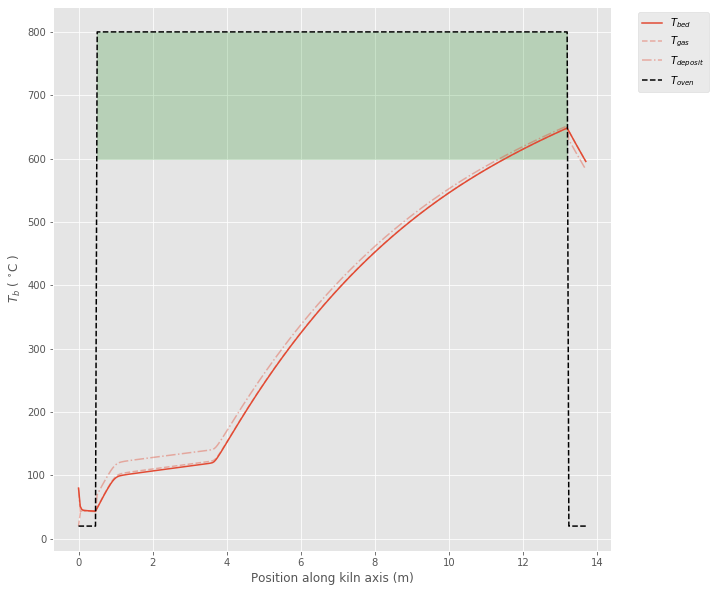

In [6]:
T_oven = [800]

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.fill_between([0.5,13.2],[600,600],[800,800], color='green', alpha=0.2)

res = run_model(T_oven=T_oven)
plt.plot(X, res['bed'    ] - 273, label=r"$T_{bed}$", color=f'C0')
plt.plot(X, res['gas'    ] - 273, label=r"$T_{gas}$", color=f'C0', linestyle='--', alpha=0.4)
plt.plot(X, res['deposit'] - 273, label=r"$T_{deposit}$", color=f'C0', linestyle='-.', alpha=0.4)

T = get_oven_temps(X, T_oven)
plt.plot(X, T, label=r'$T_{oven}$', color='k', LineStyle='--')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel(r'$T_b$ ( $^{\circ}$C )')
plt.xlabel('Position along kiln axis (m)')
plt.rcParams.update({'font.size': 18})



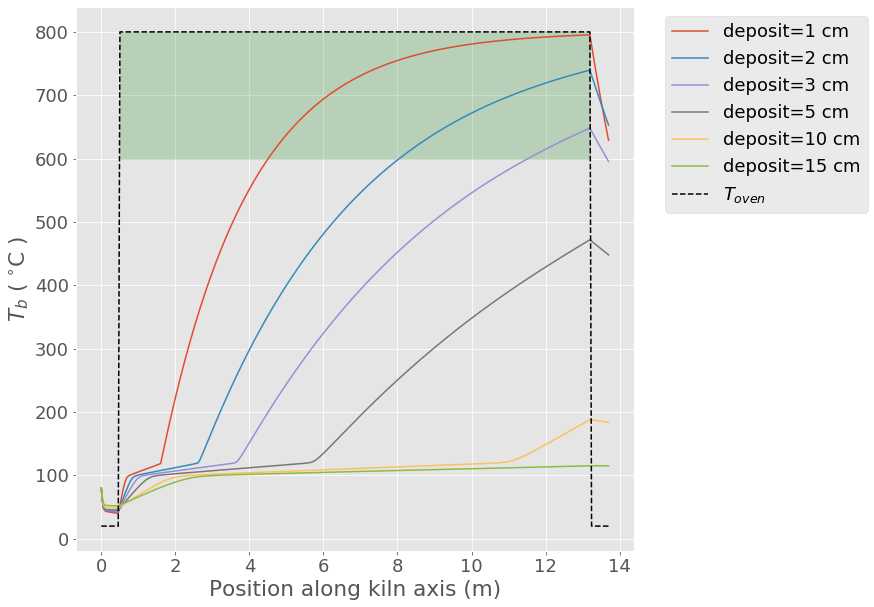

In [7]:
T_oven = [800]

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.fill_between([0.5,13.2],[600,600],[800,800], color='green', alpha=0.2)

for i, d_d in enumerate(tqdm([0.01, 0.02, 0.03, 0.05, 0.10, 0.15])):
    res = run_model(d_d=d_d, T_oven=T_oven)
    name = r'deposit={} cm'.format(int(100*d_d))
    plt.plot(X, res['bed'] - 273, label=name, color=f'C{i}')

T = get_oven_temps(X, T_oven)
plt.plot(X, T, label=r'$T_{oven}$', color='k', LineStyle='--')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel(r'$T_b$ ( $^{\circ}$C )')
plt.xlabel('Position along kiln axis (m)')
plt.rcParams.update({'font.size': 18})


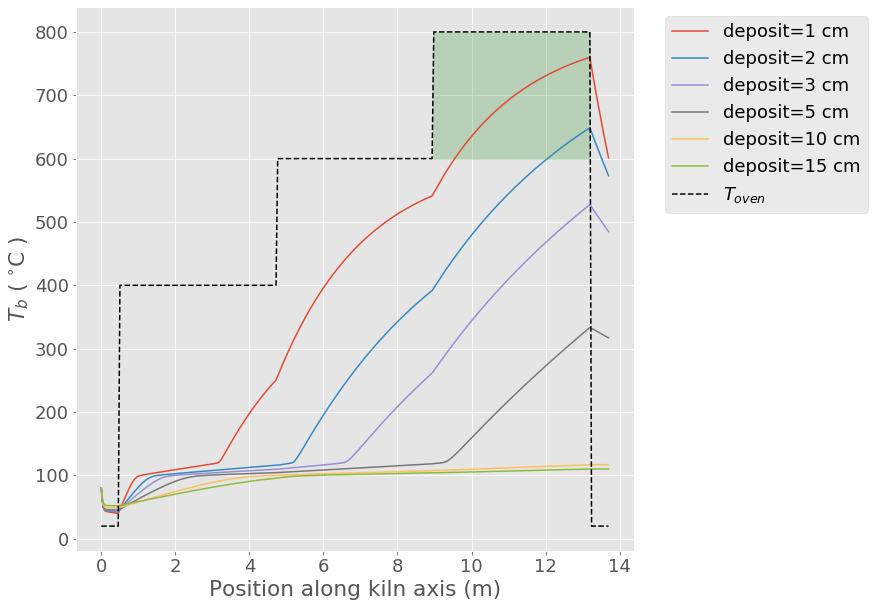

In [8]:
T_oven = [400, 600, 800]

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.fill_between([8.96,13.2],[600,600],[800,800], color='green', alpha=0.2)

for i, d_d in enumerate(tqdm([0.01, 0.02, 0.03, 0.05, 0.10, 0.15])):
    res = run_model(d_d=d_d, T_oven=T_oven)
    name = r'deposit={} cm'.format(int(100*d_d))
    plt.plot(X, res['bed'] - 273, label=name, color=f'C{i}')

T = get_oven_temps(X, T_oven)
plt.plot(X, T, label=r'$T_{oven}$', color='k', LineStyle='--')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel(r'$T_b$ ( $^{\circ}$C )')
plt.xlabel('Position along kiln axis (m)')
plt.rcParams.update({'font.size': 18})


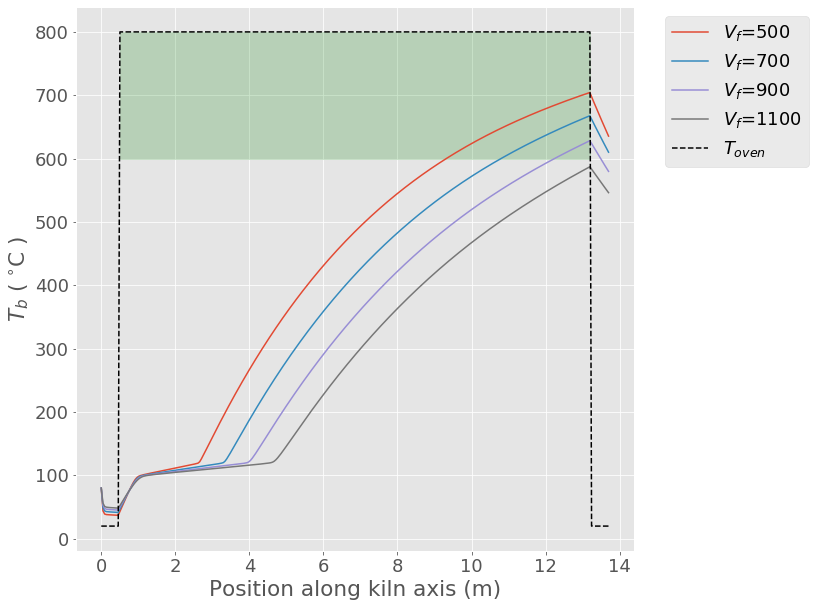

In [9]:
T_oven = [800]

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.fill_between([0.5,13.2],[600,600],[800,800], color='green', alpha=0.2)

for i, V_f in enumerate(tqdm([500, 700, 900,1100])):
    res = run_model(V_f=V_f/3600, T_oven=T_oven)
    name = r'$V_f$={}'.format(V_f)
    plt.plot(X, res['bed'] - 273, label=name, color=f'C{i}')

T = get_oven_temps(X, T_oven)
plt.plot(X, T, label=r'$T_{oven}$', color='k', LineStyle='--')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel(r'$T_b$ ( $^{\circ}$C )')
plt.xlabel('Position along kiln axis (m)')
plt.rcParams.update({'font.size': 18})


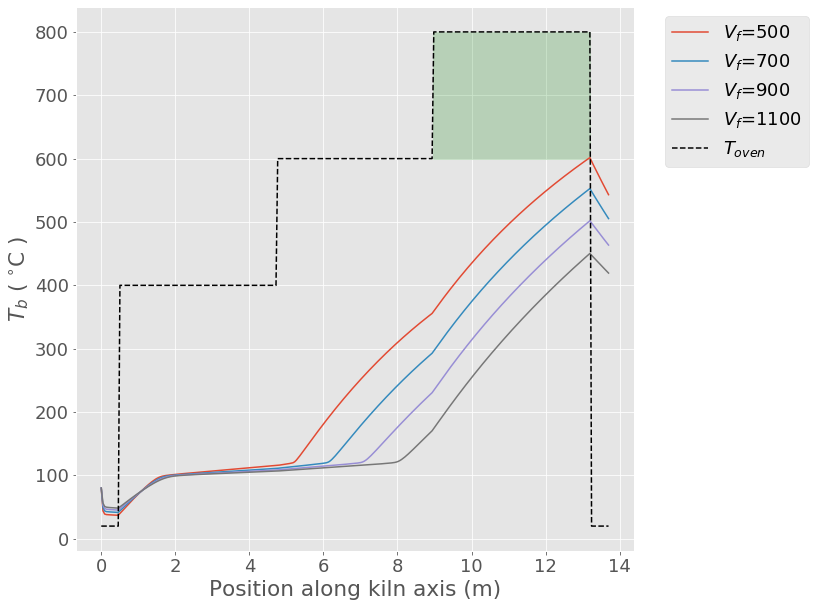

In [10]:
T_oven = [400, 600, 800]

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.fill_between([8.96,13.2],[600,600],[800,800], color='green', alpha=0.2)

for i, V_f in enumerate(tqdm([500, 700, 900,1100])):
    res = run_model(V_f=V_f/3600, T_oven=T_oven)
    name = r'$V_f$={}'.format(V_f)
    plt.plot(X, res['bed'] - 273, label=name, color=f'C{i}')

T = get_oven_temps(X, T_oven)
plt.plot(X, T, label=r'$T_{oven}$', color='k', LineStyle='--')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel(r'$T_b$ ( $^{\circ}$C )')
plt.xlabel('Position along kiln axis (m)')
plt.rcParams.update({'font.size': 18})


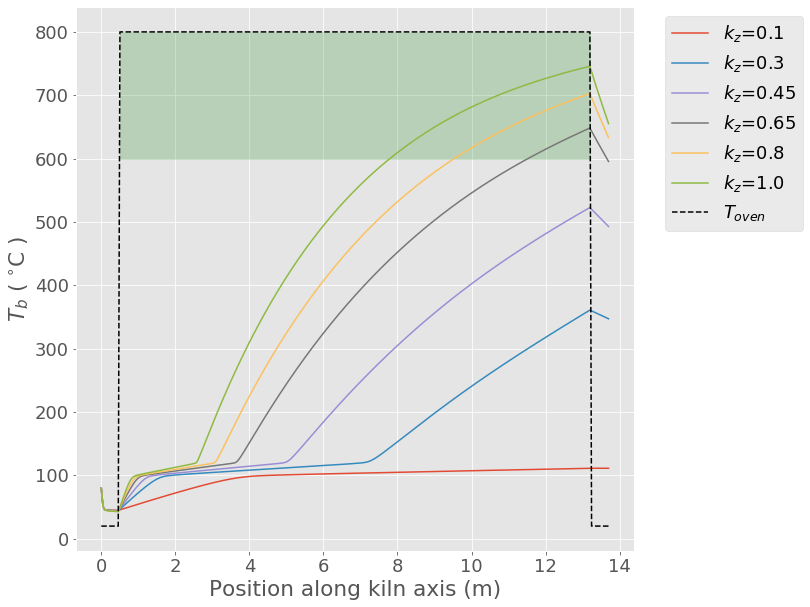

In [11]:
T_oven = [800]

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.fill_between([0.5,13.2],[600,600],[800,800], color='green', alpha=0.2)
for i, k_z in enumerate(tqdm([0.1, 0.3, 0.45, 0.65, 0.80, 1.0])):
    res = run_model(k_z=k_z, T_oven=T_oven)
    name = r'$k_z$={}'.format(k_z)
    plt.plot(X, res['bed'] - 273, label=name, color=f'C{i}')

T = get_oven_temps(X, T_oven)
plt.plot(X, T, label=r'$T_{oven}$', color='k', LineStyle='--')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel(r'$T_b$ ( $^{\circ}$C )')
plt.xlabel('Position along kiln axis (m)')
plt.rcParams.update({'font.size': 18})


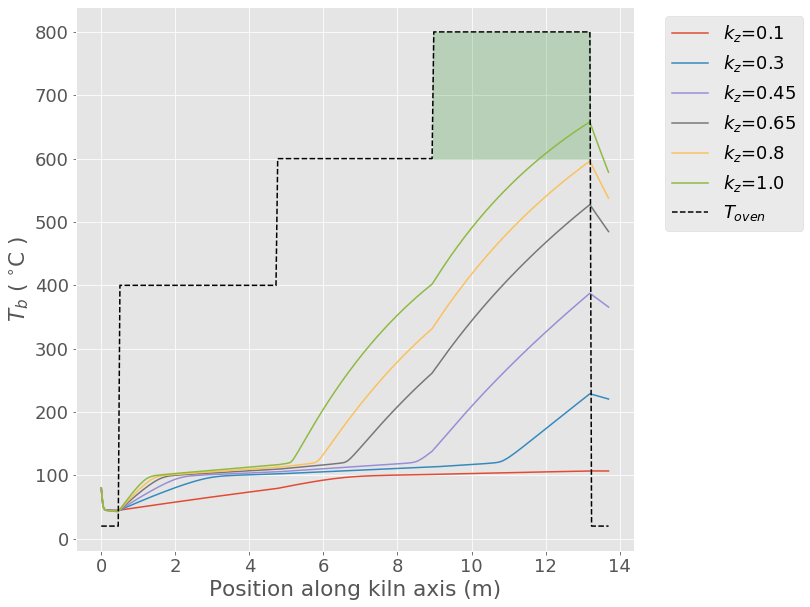

In [12]:
T_oven = [400, 600, 800]

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.fill_between([8.96,13.2],[600,600],[800,800], color='green', alpha=0.2)
for i, k_z in enumerate(tqdm([0.1, 0.3, 0.45, 0.65, 0.80, 1.0])):
    res = run_model(k_z=k_z, T_oven=T_oven)
    name = r'$k_z$={}'.format(k_z)
    plt.plot(X, res['bed'] - 273, label=name, color=f'C{i}')

T = get_oven_temps(X, T_oven)
plt.plot(X, T, label=r'$T_{oven}$', color='k', LineStyle='--')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel(r'$T_b$ ( $^{\circ}$C )')
plt.xlabel('Position along kiln axis (m)')
plt.rcParams.update({'font.size': 18})


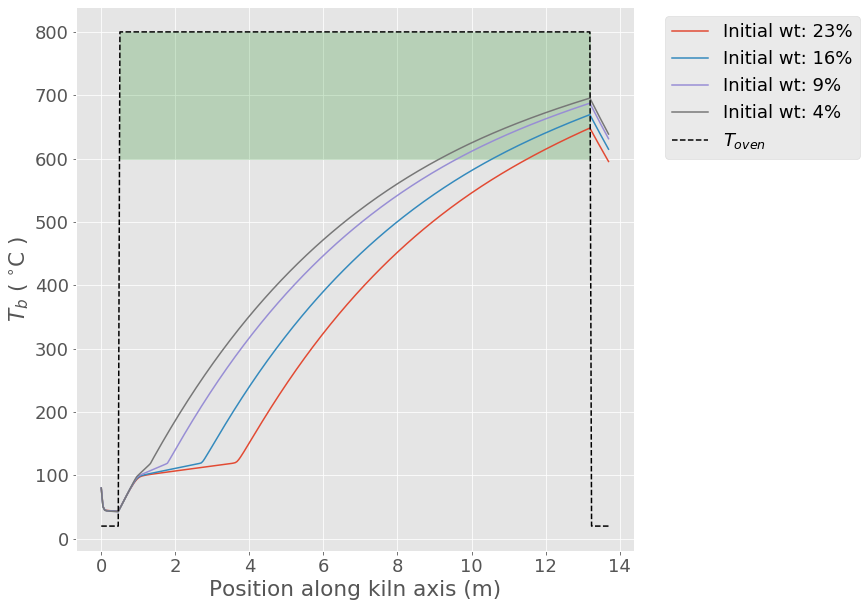

In [13]:
T_oven = [800]

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.fill_between([0.5,13.2],[600,600],[800,800], color='green', alpha=0.2)
for i, initial_moisture in enumerate(tqdm([0.3, 0.2, 0.1, 0.05])):
    res = run_model(initial_moisture=initial_moisture, T_oven=T_oven)
    name = r'Initial wt: {}%'.format(int(100 * initial_moisture / (initial_moisture + 1) ))
    plt.plot(X, res['bed'] - 273, label=name, color=f'C{i}')

T = get_oven_temps(X, T_oven)
plt.plot(X, T, label=r'$T_{oven}$', color='k', LineStyle='--')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel(r'$T_b$ ( $^{\circ}$C )')
plt.xlabel('Position along kiln axis (m)')
plt.rcParams.update({'font.size': 18})


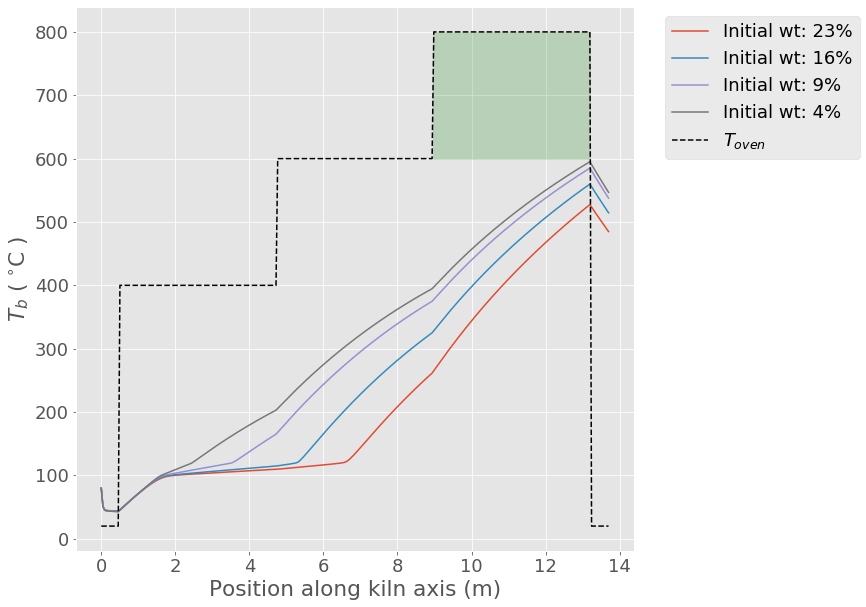

In [14]:
T_oven = [400, 600, 800]

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.fill_between([8.96,13.2],[600,600],[800,800], color='green', alpha=0.2)
for i, initial_moisture in enumerate(tqdm([0.3, 0.2, 0.1, 0.05])):
    res = run_model(initial_moisture=initial_moisture, T_oven=T_oven)
    name = r'Initial wt: {}%'.format(int(100 * initial_moisture / (initial_moisture + 1) ))
    plt.plot(X, res['bed'] - 273, label=name, color=f'C{i}')

T = get_oven_temps(X, T_oven)
plt.plot(X, T, label=r'$T_{oven}$', color='k', LineStyle='--')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel(r'$T_b$ ( $^{\circ}$C )')
plt.xlabel('Position along kiln axis (m)')
plt.rcParams.update({'font.size': 18})


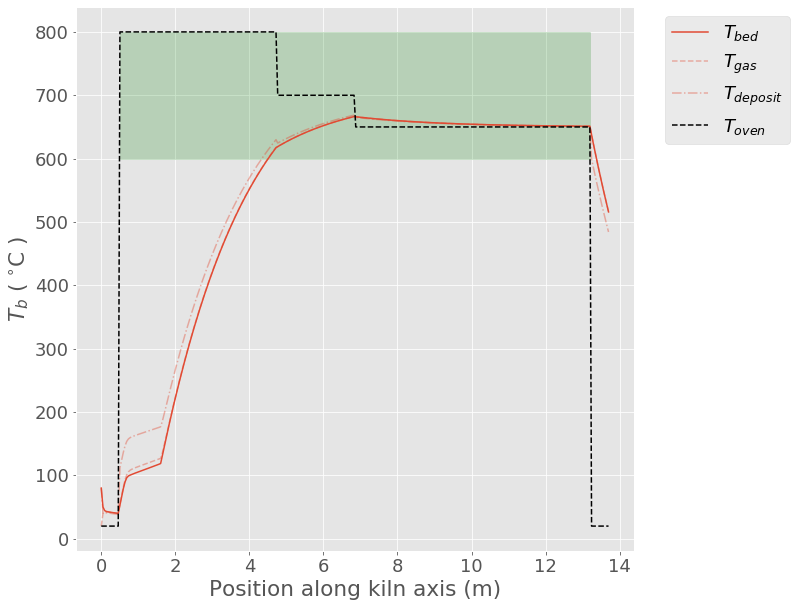

In [15]:
T_oven = [800,800,700,650,650,650]

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.fill_between([0.5,13.2],[600,600],[800,800], color='green', alpha=0.2)

res = run_model(T_oven=T_oven, d_d=0.01)
plt.plot(X, res['bed'    ] - 273, label=r"$T_{bed}$", color='C0')
plt.plot(X, res['gas'    ] - 273, label=r"$T_{gas}$", color='C0', linestyle='--', alpha=0.4)
plt.plot(X, res['deposit'] - 273, label=r"$T_{deposit}$", color='C0', linestyle='-.', alpha=0.4)

T = get_oven_temps(X, T_oven)
plt.plot(X, T, label=r'$T_{oven}$', color='k', LineStyle='--')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel(r'$T_b$ ( $^{\circ}$C )')
plt.xlabel('Position along kiln axis (m)')
plt.rcParams.update({'font.size': 18})

